In [1]:
import networkx as nx
import seir
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats as st
import itertools as it
from tqdm import tqdm_notebook as tqdm

The first modification to the simulation we're implementing is dynamic graphs; the graph over which the simulation operates changes over time.

We're going to simulate "movement" throughout the day as "periods", like in high school. I'm assuming location information from the app can be chunked into periods. We'll assume that the people at a location in a particular period are isolated, that is, for that period they can only transmit to each other. People travel to different locations between periods however. Given n periods, we're going to need a list of n graphs. 

In [2]:
names=[]
nperiods=10
npeople=20  #maxes out at 148
with open('sample_names.rtf') as f:
    names.append(f.readlines())
fmt_names =list(set([x.strip().replace(' \\\'a0\\','') for x in names[0][8:]]))[:npeople]
locations=['Rustem Lab', 'Pierce Lab', 'Arnold Lab','Broad','Noyes','Schlinger','Spaulding']


schedule = np.random.choice(locations,size=nperiods*len(fmt_names)) 
schedule = np.reshape(schedule,newshape=[nperiods,len(fmt_names)])
schedule_df = pd.DataFrame(schedule,columns=fmt_names)
schedule_df.head()

,Shawn,Brandon,Kanesha,Elaine,Luetta },Tia,Freddy,Shirl,Carletta,Christie,America,Theressa,Domenica,Graciela,Kisha,Yesenia,Maybell,Gregoria,Leonel,Vivienne
0,Spaulding,Rustem Lab,Broad,Noyes,Schlinger,Broad,Noyes,Rustem Lab,Rustem Lab,Schlinger,Arnold Lab,Arnold Lab,Rustem Lab,Schlinger,Rustem Lab,Schlinger,Broad,Arnold Lab,Broad,Spaulding
1,Arnold Lab,Pierce Lab,Noyes,Broad,Arnold Lab,Broad,Schlinger,Broad,Pierce Lab,Arnold Lab,Spaulding,Noyes,Schlinger,Broad,Pierce Lab,Pierce Lab,Pierce Lab,Broad,Pierce Lab,Pierce Lab
2,Broad,Spaulding,Schlinger,Broad,Spaulding,Spaulding,Rustem Lab,Broad,Arnold Lab,Pierce Lab,Arnold Lab,Pierce Lab,Noyes,Rustem Lab,Noyes,Broad,Spaulding,Pierce Lab,Spaulding,Broad
3,Pierce Lab,Noyes,Spaulding,Rustem Lab,Spaulding,Schlinger,Schlinger,Arnold Lab,Schlinger,Broad,Rustem Lab,Spaulding,Arnold Lab,Noyes,Broad,Broad,Noyes,Pierce Lab,Pierce Lab,Noyes
4,Rustem Lab,Schlinger,Noyes,Noyes,Schlinger,Broad,Rustem Lab,Schlinger,Broad,Broad,Arnold Lab,Schlinger,Broad,Pierce Lab,Broad,Pierce Lab,Noyes,Schlinger,Broad,Pierce Lab


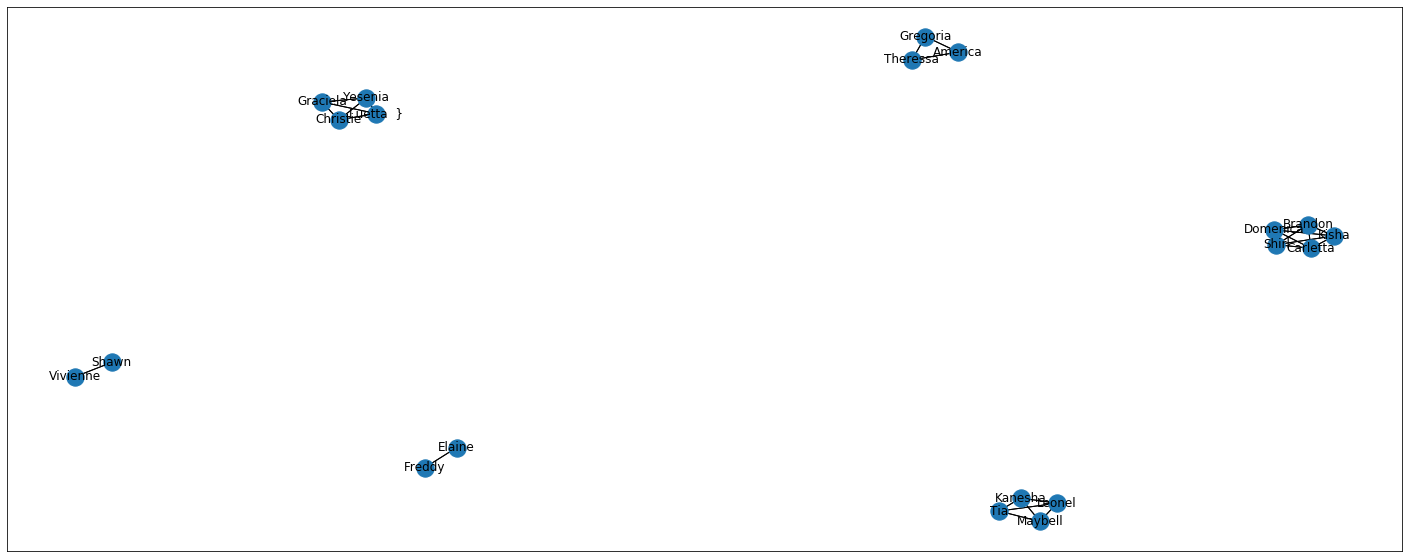

In [3]:
#let's generate a graph based on the schedule
G_list = []

for period_idx in range(len(schedule_df.index)):
    G = nx.MultiGraph()
    G.add_nodes_from(fmt_names)
    edgelist=[]
    current_series = schedule_df.iloc[period_idx]
    #full-connect all individuals at the same location
    for location_idx in range(len(locations)):
        current_location = locations[location_idx]
        current_names = list(current_series[current_series==current_location].index)
        edgelist.append(list(it.product(current_names,current_names)))
        
    #we need to concatenate all the edges into a single list
    edgelist=sum(edgelist,[])
    G.add_edges_from(edgelist)
    G_list.append(G)
G_list
nx.draw_networkx(G_list[0],nodelist=fmt_names)

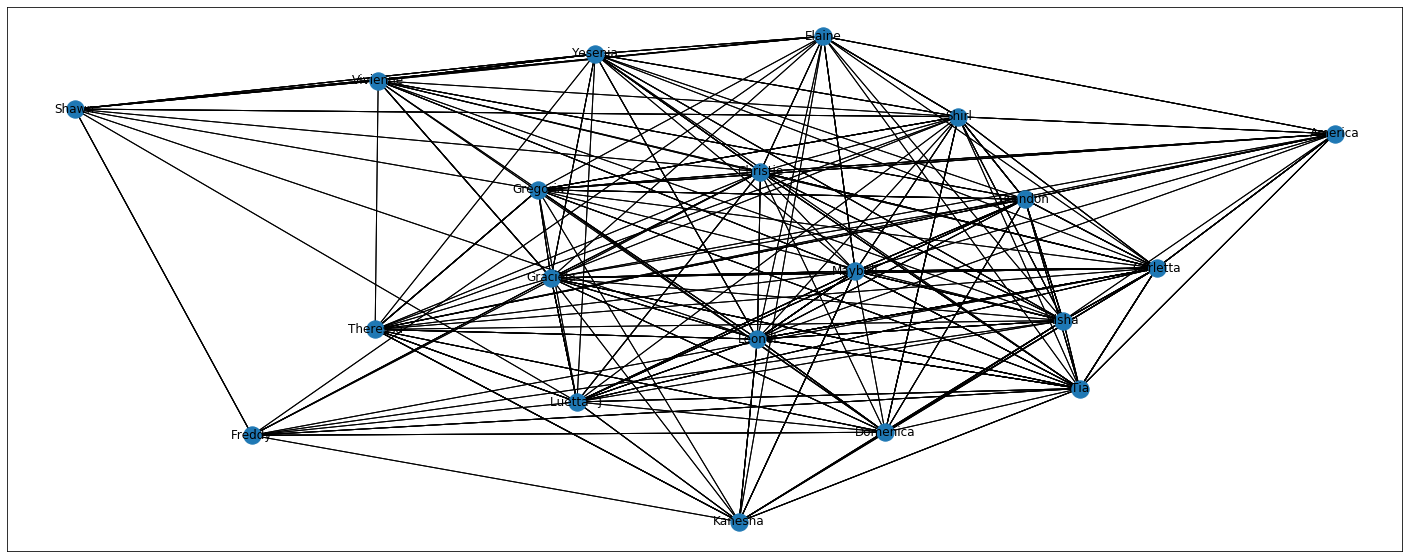

In [4]:
#let's a large graph over all periods to vizualize the entire day at once
G = nx.MultiGraph()
G.add_nodes_from(fmt_names)
edgelist=[]


for period_idx in range(len(schedule_df.index)):

    current_series = schedule_df.iloc[period_idx]
    #full-connect all individuals at the same location
    for location_idx in range(len(locations)):
        current_location = locations[location_idx]
        current_names = list(current_series[current_series==current_location].index)
        edgelist.append(list(it.product(current_names,current_names)))
        
    #we need to concatenate all the edges into a single list
edgelist=sum(edgelist,[])
G.add_edges_from(edgelist)

nx.draw_networkx(G)

Looks like we can generate graphs adequately. Let's work on plugging this into the seir module. I need to know how to run seir models with custom initial states. Running a trial SEIR model to see what output looks like

In [5]:
res1 = seir.simulation(G=G_list,prob_exposed_detected=0.1,verbose=False)
res1.summary()

duration                    7.666667
fraction_infected           0.700000
doubling_days                    inf
fraction_quarantine_time    0.497917
peak_infected_time          0.000000
peak_fraction_infected      0.500000
fraction_tests              0.649774
peak_test_rate              0.097083
dtype: float64


Constructing confidence intervals around SEIR runs...

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Text(0, 0.5, 'Fraction')

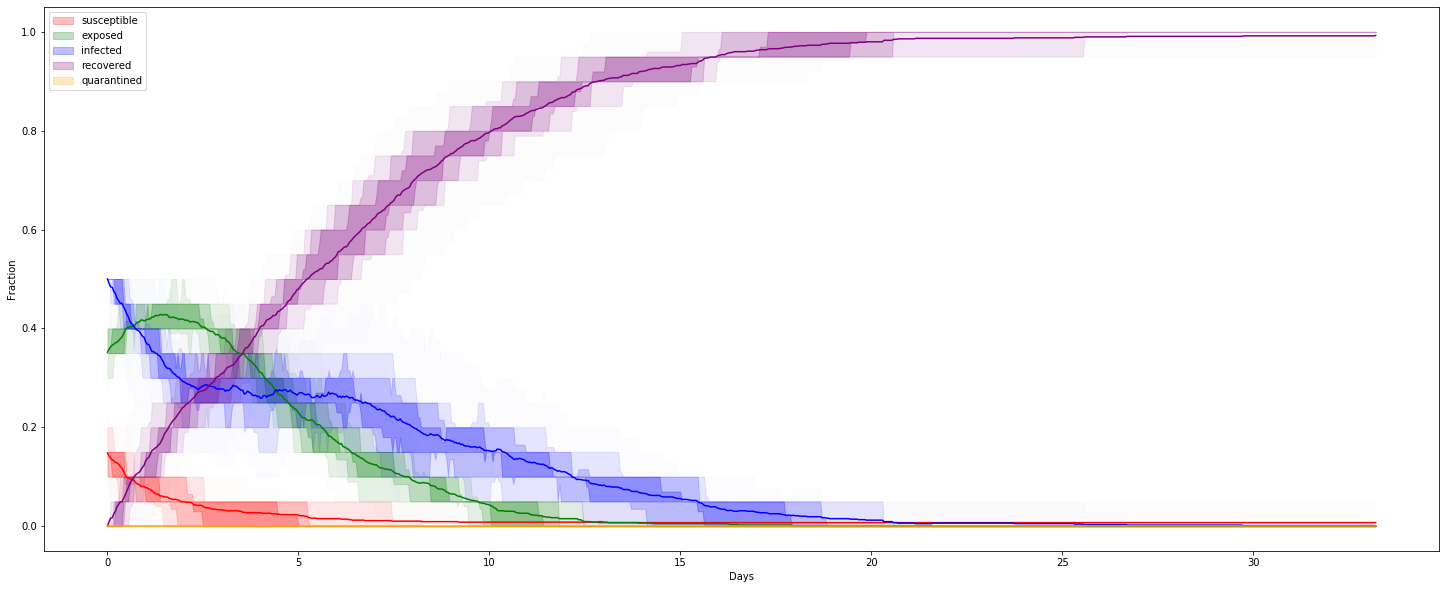

In [9]:
ntrials = 50
G=G

colorlist=['red','green','blue','purple','orange']
species = ['susceptible','exposed','infected','recovered','quarantined']
alphalist = np.linspace(0.01,0.25,4)
triallist=[[],[],[],[],[],[]]
for trial_idx in tqdm(range(ntrials)):
    
    result = seir.simulation(G=G,prob_exposed_detected=0.,prob_infected_detected=0.,prob_neighbor_detected=0.,verbose=False)
    
    triallist[0].append(result.df['day'].values)
    triallist[1].append(result.df['susceptible'].values / result.N)
    triallist[2].append(result.df['exposed'].values / result.N)
    triallist[3].append(result.df['infected'].values / result.N)
    triallist[4].append(result.df['recovered'].values / result.N)
    triallist[5].append(result.df['quarantined'].values / result.N)

#we need to create a master timelist from the xaxes of all trials
xax = np.unique(np.concatenate(triallist[0]))
outputarray = np.empty(shape=[xax.size,ntrials,5])  #5 in the last dimension represents seirq

for time_idx in range(xax.size):
    current_time = xax[time_idx]
    for trial_idx in range(ntrials):
        for species_idx in range(len(species)):
            #going by "price is right rules", closest time to x without going over
            insert_idx = min([np.searchsorted(triallist[0][trial_idx],current_time),triallist[0][trial_idx].size-1])
            outputarray[time_idx,trial_idx,species_idx] = triallist[species_idx+1][trial_idx][insert_idx]  #the +1 is because I added the xaxis to the front of the list

            
fig,ax = plt.subplots()
for species_idx in range(len(species)):
    ax.fill_between(xax,np.percentile(outputarray[:,:,species_idx],5,axis=1),np.percentile(outputarray[:,:,species_idx],95,axis=1),color=colorlist[species_idx],alpha=alphalist[0])
    ax.fill_between(xax,np.percentile(outputarray[:,:,species_idx],20,axis=1),np.percentile(outputarray[:,:,species_idx],80,axis=1),color=colorlist[species_idx],alpha=alphalist[1])
    ax.fill_between(xax,np.percentile(outputarray[:,:,species_idx],30,axis=1),np.percentile(outputarray[:,:,species_idx],70,axis=1),color=colorlist[species_idx],alpha=alphalist[2])
    ax.fill_between(xax,np.percentile(outputarray[:,:,species_idx],40,axis=1),np.percentile(outputarray[:,:,species_idx],60,axis=1),color=colorlist[species_idx],alpha=alphalist[3],label=species[species_idx])
    ax.plot(xax,np.mean(np.squeeze(outputarray[:,:,species_idx]),axis=1),color=colorlist[species_idx])
    ax.legend()
ax.set_xlabel('Days')
ax.set_ylabel('Fraction')

In [7]:
outputarray.shape

(609, 50, 5)

In [8]:
np.percentile(outputarray[:,:,0],95,axis=1).shape

(609,)